# Multi-Label Classification
---
## Plant Seedling Classification

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
%matplotlib inline
import os
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
from glob import glob
import seaborn as sns

In [4]:
PATH1 = 'data/plant/'

In [5]:
ls{PATH1}

sample_submission.csv.zip  test/  train/


In [6]:
files = !ls {PATH1}train/**/*.png
files[0:10]

['data/plant/train/Black-grass/0050f38b3.png',
 'data/plant/train/Black-grass/0183fdf68.png',
 'data/plant/train/Black-grass/0260cffa8.png',
 'data/plant/train/Black-grass/05eedce4d.png',
 'data/plant/train/Black-grass/075d004bc.png',
 'data/plant/train/Black-grass/078eae073.png',
 'data/plant/train/Black-grass/082314602.png',
 'data/plant/train/Black-grass/0ace21089.png',
 'data/plant/train/Black-grass/0b228a6b8.png',
 'data/plant/train/Black-grass/0b3e7a7a9.png']

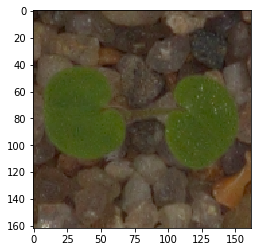

In [7]:
img = plt.imread(files[random.randint(0,len(files))])
plt.imshow(img);

In [385]:
BASE_DATA_FOLDER = PATH1
TRAin_DATA_FOLDER = os.path.join(BASE_DATA_FOLDER, "train")
TEST_DATA_FOLDER = os.path.join(BASE_DATA_FOLDER, "test")

In [10]:
TRAin_DATA_FOLDER

'data/plant/train'

In [386]:
TEST_DATA_FOLDER

'data/plant/test'

### Read images
---
First, read all the images. The images are in BGR (Blue/Green/Red) format because OpenCV uses this.

Btw... If you'd like to use RGB format, than you can use it, it won't effect the segmentation because we will use the HSV (Hue/Saturation/Value) color space for that.

In [11]:
images_per_class = {}
for class_folder_name in os.listdir(TRAin_DATA_FOLDER):
    class_folder_path = os.path.join(TRAin_DATA_FOLDER, class_folder_name)
    class_label = class_folder_name
    images_per_class[class_label] = []
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
        images_per_class[class_label].append(image_bgr)

In [12]:
images_per_class

{'Black-grass': [array([[[120, 123, 115],
          [137, 142, 131],
          [132, 138, 128],
          ...,
          [195, 187, 181],
          [193, 187, 180],
          [191, 186, 180]],
  
         [[132, 133, 124],
          [150, 153, 139],
          [149, 153, 139],
          ...,
          [197, 189, 182],
          [194, 187, 181],
          [193, 187, 181]],
  
         [[140, 140, 131],
          [161, 163, 149],
          [162, 165, 149],
          ...,
          [197, 188, 182],
          [197, 189, 182],
          [196, 188, 182]],
  
         ...,
  
         [[ 43,  56,  77],
          [ 40,  56,  76],
          [ 32,  51,  71],
          ...,
          [ 59,  68,  84],
          [ 65,  72,  89],
          [ 67,  72,  88]],
  
         [[ 43,  56,  76],
          [ 40,  57,  76],
          [ 40,  59,  78],
          ...,
          [ 55,  64,  80],
          [ 60,  68,  84],
          [ 64,  70,  87]],
  
         [[ 42,  57,  75],
          [ 44,  61,  79],
         

In [13]:
for key,value in images_per_class.items():
    print("{0} -> {1}".format(key, len(value)))

Small-flowered Cranesbill -> 496
Black-grass -> 263
Loose Silky-bent -> 654
Fat Hen -> 475
Common Chickweed -> 611
Shepherds Purse -> 231
Common wheat -> 221
Scentless Mayweed -> 516
Sugar beet -> 385
Cleavers -> 287
Charlock -> 390
Maize -> 221


### Plot images
---
Plot images so we can see what the input looks like

In [14]:
def plot_for_class(label):
    nb_rows = 3
    nb_cols = 3
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(6, 6))

    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].xaxis.set_ticklabels([])
            axs[i, j].yaxis.set_ticklabels([])
            axs[i, j].imshow(images_per_class[label][n])
            n += 1

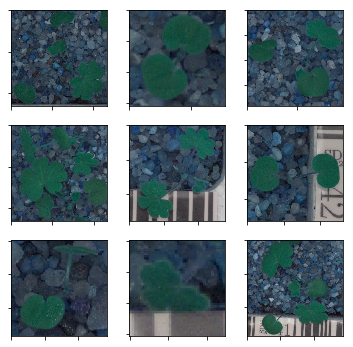

In [15]:
plot_for_class("Small-flowered Cranesbill")

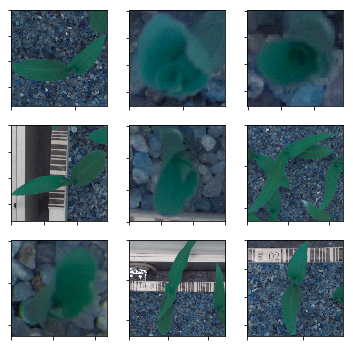

In [16]:
plot_for_class("Maize")

### Pre-processing for images (Image segmentation)
---

In [401]:
def create_mask_for_plant(image):
    '''
    This function returns an image mask: 
    A matrix with shape (image_height, image_width). In this matrix there are only 0 and 1 values. 
    The 1 values define the interesting part of the original image. 
    '''
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    '''
    The HSV color-space is suitable for color detection because with the Hue we can define the color 
    and the saturation and value will define "different kinds" of the color. (For example it will 
    detect the red, darker red, lighter red too). We cannot do this with the original BGR color space.
    '''
    #sensitivity = 60
    #lower_hsv = np.array([65 - sensitivity, 55, 10])
    #upper_hsv = np.array([65 + sensitivity, 255, 255])
    
    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    
    '''We have to set a range, which color should be detected'''
    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    '''Create the mask with the inRange function'''
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    '''Morphological operation'''
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    '''We keep the shape of the original objects (1 blobs on the mask image) but close the small holes. 
    That way we can clarify our detection mask more.
    '''

    return mask

In [402]:
def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

In [403]:
def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

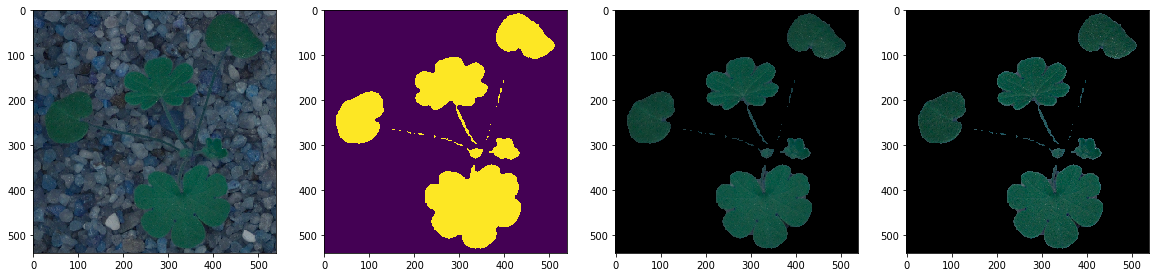

In [404]:
# Test image to see the changes
image = images_per_class["Small-flowered Cranesbill"][49]

image_mask = create_mask_for_plant(image)
image_segmented = segment_plant(image)
image_sharpen = sharpen_image(image_segmented)

fig, axs = plt.subplots(1, 4, figsize=(20, 20))
axs[0].imshow(image)
axs[1].imshow(image_mask)
axs[2].imshow(image_segmented)
axs[3].imshow(image_sharpen)
plt.show()

In [405]:
def find_contours(mask_image):
    return cv2.findContours(mask_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]

def calculate_largest_contour_area(contours):
    if len(contours) == 0:
        return 0
    c = max(contours, key=cv2.contourArea)
    return cv2.contourArea(c)

def calculate_contours_area(contours, min_contour_area = 250):
    area = 0
    for c in contours:
        c_area = cv2.contourArea(c)
        if c_area >= min_contour_area:
            area += c_area
    return area

In [406]:
areas = []
larges_contour_areas = []
labels = []
nb_of_contours = []
images_height = []
images_width = []

for class_label in images_per_class.keys():
    for image in images_per_class[class_label]:
        mask = create_mask_for_plant(image)
        contours = find_contours(mask)
        
        area = calculate_contours_area(contours)
        largest_area = calculate_largest_contour_area(contours)
        height, width, channels = image.shape
        
        images_height.append(height)
        images_width.append(width)
        areas.append(area)
        nb_of_contours.append(len(contours))
        larges_contour_areas.append(largest_area)
        labels.append(class_label)

In [407]:
features_df = pd.DataFrame()
features_df["label"] = labels
features_df["area"] = areas
features_df["largest_area"] = larges_contour_areas
features_df["number_of_components"] = nb_of_contours
features_df["height"] = images_height
features_df["width"] = images_width

In [408]:
features_df.groupby("label").describe()

area                                        \
                           count           mean            std     min   
label                                                                    
Black-grass                263.0   41793.982890  159636.952451     0.0   
Charlock                   390.0   91669.094872  150626.968468  3177.5   
Cleavers                   287.0   25619.073171   24726.375631   567.5   
Common Chickweed           611.0   14935.878887   20172.494215     0.0   
Common wheat               221.0    6949.357466    8161.181143     0.0   
Fat Hen                    475.0   30623.629474   67760.225738   512.0   
Loose Silky-bent           654.0   24618.366208  132431.879535     0.0   
Maize                      221.0  115311.341629  206882.627747   851.5   
Scentless Mayweed          516.0   15517.381783   27678.754205     0.0   
Shepherds Purse            231.0   38187.586580   66440.811037   562.0   
Small-flowered Cranesbill  496.0   38126.337702   48735.741208   678.5   
Sugar beet                 385.0   79003.370130  112091.057669     0.0   

                                                                      height  \
                                 25%       50%         75%        max  count   
label                                                                          
Black-grass                 1559.750   7204.00   23556.250  2097133.5  263.0   
Charlock                   12795.125  39382.25   80786.125  1193936.5  390.0   
Cleavers                    8368.000  18717.50   34363.000   175187.0  287.0   
Common Chickweed            1917.500   5026.00   25140.000   131654.5  611.0   
Common wheat                1883.000   4044.50    8953.000    57880.0  221.0   
Fat Hen                     2804.250   6153.50   28209.000   561161.5  475.0   
Loose Silky-bent             718.500   1795.50    8252.500  1930040.5  654.0   
Maize                       3885.500  52033.00  119356.000  1435536.5  221.0   
Scentless Mayweed           1589.250   3314.25   14044.125   198328.5  516.0   
Shepherds Purse             3303.500   7435.50   45623.250   415662.5  231.0   
Small-flowered Cranesbill   7834.625  16201.50   42556.500   306815.5  496.0   
Sugar beet                 16029.000  40748.50   81174.000   815699.0  385.0   

                                        ...   number_of_components         \
                                 mean   ...                    75%    max   
label                                   ...                                 
Black-grass                661.307985   ...                  22.00  195.0   
Charlock                   431.976923   ...                   2.75   61.0   
Cleavers                   310.292683   ...                   4.00   32.0   
Common Chickweed           230.708674   ...                   2.00   24.0   
Common wheat               440.167421   ...                  37.00  203.0   
Fat Hen                    303.008421   ...                   5.00   88.0   
Loose Silky-bent           397.897554   ...                  12.00  305.0   
Maize                      483.239819   ...                   4.00   87.0   
Scentless Mayweed          226.003876   ...                   2.00  123.0   
Shepherds Purse            288.541126   ...                   2.00   49.0   
Small-flowered Cranesbill  342.316532   ...                  10.00   92.0   
Sugar beet                 590.309091   ...                   4.00   19.0   

                           width                                         \
                           count        mean         std    min     25%   
label                                                                     
Black-grass                263.0  668.638783  520.794148   73.0  290.00   
Charlock                   390.0  431.982051  287.746036  121.0  188.00   
Cleavers                   287.0  310.292683  151.918747   66.0  171.50   
Common Chickweed           611.0  230.708674  160.842547   54.0  107.50   
Common wheat               221.0  4

In [394]:
images_per_class["Small-flowered Cranesbill"][49]

array([[[ 31,  49,  70],
        [ 29,  50,  70],
        [ 29,  50,  72],
        ...,
        [101, 114, 125],
        [ 93, 104, 116],
        [ 76,  86, 100]],

       [[ 26,  44,  67],
        [ 29,  49,  71],
        [ 30,  50,  73],
        ...,
        [ 97, 109, 123],
        [ 94, 104, 119],
        [ 73,  82,  98]],

       [[ 34,  49,  71],
        [ 30,  49,  72],
        [ 29,  50,  73],
        ...,
        [100, 110, 125],
        [ 95, 105, 120],
        [ 83,  91, 108]],

       ...,

       [[ 55,  63,  73],
        [ 55,  63,  73],
        [ 55,  64,  74],
        ...,
        [ 63,  75,  92],
        [ 75,  87, 100],
        [ 88, 100, 111]],

       [[ 57,  65,  75],
        [ 53,  62,  71],
        [ 56,  66,  75],
        ...,
        [ 60,  73,  90],
        [ 70,  82,  98],
        [ 73,  84,  98]],

       [[ 59,  67,  78],
        [ 58,  67,  77],
        [ 55,  65,  75],
        ...,
        [ 72,  84, 101],
        [ 72,  84, 101],
        [ 72,  84, 100]]

In [395]:
images_per_class["Small-flowered Cranesbill"][49][mask]

array([[[[ 23,  51,  84],
         [ 28,  54,  90],
         [ 24,  51,  88],
         ...,
         [ 70,  79,  95],
         [ 63,  72,  90],
         [ 67,  79,  96]],

        [[ 23,  51,  84],
         [ 28,  54,  90],
         [ 24,  51,  88],
         ...,
         [ 70,  79,  95],
         [ 63,  72,  90],
         [ 67,  79,  96]],

        [[ 23,  51,  84],
         [ 28,  54,  90],
         [ 24,  51,  88],
         ...,
         [ 70,  79,  95],
         [ 63,  72,  90],
         [ 67,  79,  96]],

        ...,

        [[ 23,  51,  84],
         [ 28,  54,  90],
         [ 24,  51,  88],
         ...,
         [ 70,  79,  95],
         [ 63,  72,  90],
         [ 67,  79,  96]],

        [[ 23,  51,  84],
         [ 28,  54,  90],
         [ 24,  51,  88],
         ...,
         [ 70,  79,  95],
         [ 63,  72,  90],
         [ 67,  79,  96]],

        [[ 23,  51,  84],
         [ 28,  54,  90],
         [ 24,  51,  88],
         ...,
         [ 70,  79,  95],
        

In [400]:
images_per_class['Black-grass'][0][0]

array([[120, 123, 115],
       [137, 142, 131],
       [132, 138, 128],
       [120, 127, 122],
       [ 99, 107, 110],
       [ 81,  91, 101],
       [ 74,  85,  98],
       [ 85,  94, 107],
       [102, 107, 117],
       [130, 131, 132],
       [151, 149, 143],
       [167, 164, 151],
       [179, 175, 161],
       [186, 181, 168],
       [192, 187, 176],
       [193, 188, 179],
       [190, 185, 177],
       [191, 185, 177],
       [191, 183, 176],
       [193, 183, 177],
       [193, 183, 177],
       [193, 182, 176],
       [192, 182, 175],
       [195, 185, 179],
       [190, 181, 175],
       [190, 180, 175],
       [188, 180, 174],
       [184, 177, 168],
       [178, 173, 163],
       [165, 162, 153],
       [149, 148, 143],
       [128, 128, 129],
       [100, 103, 107],
       [ 78,  86,  90],
       [ 59,  75,  76],
       [ 47,  70,  67],
       [ 47,  72,  67],
       [ 46,  71,  66],
       [ 48,  71,  66],
       [ 49,  72,  68],
       [ 57,  76,  75],
       [ 69,  83

## Create Label File
---
### Iterate through training dataset and count the number of files in each subdirectory

In [7]:
ls{'data/plant/train'}

Black-grass/  Common Chickweed/  Loose Silky-bent/   Shepherds Purse/
Charlock/     Common wheat/      Maize/              Small-flowered Cranesbill/
Cleavers/     Fat Hen/           Scentless Mayweed/  Sugar beet/


In [8]:
from glob import glob
import pandas as pd

df = pd.DataFrame(columns=["file", "species"])

for image in glob(f'{PATH}train/**/*.png'):
    dir_ = image.split('/')
    file_, species = dir_[-1], dir_[-2]

    df = df.append({
        "file": file_,
        "species": species
        }, ignore_index=True)

df.to_csv('labels.csv', index=False)

In [9]:
df.head(10)

file                    species
0  e82c4271a.png  Small-flowered Cranesbill
1  8ee5d6835.png  Small-flowered Cranesbill
2  d7ecdaabe.png  Small-flowered Cranesbill
3  985e72cfb.png  Small-flowered Cranesbill
4  2a1966ff8.png  Small-flowered Cranesbill
5  29ed37400.png  Small-flowered Cranesbill
6  feea57708.png  Small-flowered Cranesbill
7  04559c69c.png  Small-flowered Cranesbill
8  5861480ff.png  Small-flowered Cranesbill
9  0ff5ac7e1.png  Small-flowered Cranesbill

In [10]:
ls{PATH}

sample_submission.csv.zip  test/  train/


## Data Augmentation
---
### Switch to data/seedlings/ folder

In [7]:
PATH = 'data/seedlings/'

In [8]:
ls{PATH}

adas-submission-2.csv  labels.csv             submission2.csv  tmp/
adas-submission.csv    models/                submission.csv   train/
labels2.csv            sample_submission.csv  test/


In [9]:
import pandas as pd
df2 = pd.read_csv('labels.csv')
df2.head(10)

file                    species
0  e82c4271a.png  Small-flowered Cranesbill
1  8ee5d6835.png  Small-flowered Cranesbill
2  d7ecdaabe.png  Small-flowered Cranesbill
3  985e72cfb.png  Small-flowered Cranesbill
4  2a1966ff8.png  Small-flowered Cranesbill
5  29ed37400.png  Small-flowered Cranesbill
6  feea57708.png  Small-flowered Cranesbill
7  04559c69c.png  Small-flowered Cranesbill
8  5861480ff.png  Small-flowered Cranesbill
9  0ff5ac7e1.png  Small-flowered Cranesbill

PyTorch doesn't like species names with spaces in them. We need to use a bit of regex-fu to replace the blank spaces with '-'

In [10]:
#df3 = df2.copy()
#df3.replace('\s+', '-',regex=True,inplace=True)
#df3.to_csv('data/seedlings/labels2.csv', index=False)

## Run from here
---

In [11]:
sz = 390
arch=resnext50
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)

In [12]:
def get_augs():
    data = ImageClassifierData.from_csv(PATH, folder='train', csv_fname=f'{PATH}labels.csv',
                                        val_idxs=get_cv_idxs(n=4750), bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

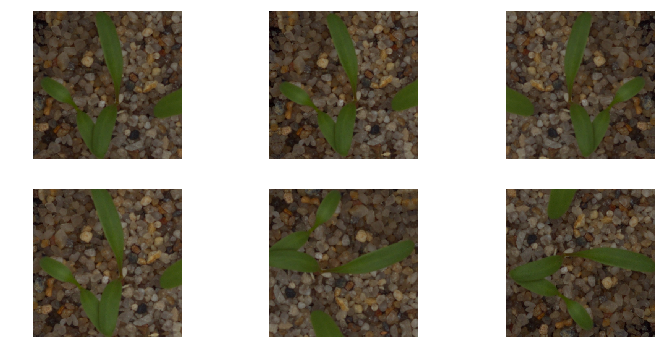

In [13]:
ims = np.stack([get_augs() for i in range(6)])
plots(ims, rows=2)

## Train the model

In [14]:
!ls {PATH}

adas-submission-2.csv  labels.csv	      submission2.csv  tmp
adas-submission.csv    models		      submission.csv   train
labels2.csv	       sample_submission.csv  test


In [17]:
tfms = tfms
data = ImageClassifierData.from_csv(PATH, folder='train', csv_fname=f'{PATH}labels2.csv',
                                    tfms=tfms, val_idxs=get_cv_idxs(n=4750), test_name='test', bs=16)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 10)

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.894461   0.539588   0.826042  
    1      0.770319   0.411228   0.866667                     
    2      0.581134   0.356406   0.884375                     
    3      0.495625   0.386664   0.875                        
    4      0.454082   0.359912   0.884375                     
    5      0.427764   0.361871   0.869792                     
    6      0.34521    0.335126   0.89375                      
    7      0.343892   0.284305   0.914583                     
    8      0.267271   0.285532   0.913542                     
    9      0.254343   0.316013   0.9                          



[0.3160134, 0.9]

In [18]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [19]:
lrf = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 75%|███████▍  | 178/238 [00:01<00:00, 115.97it/s, loss=7.47]


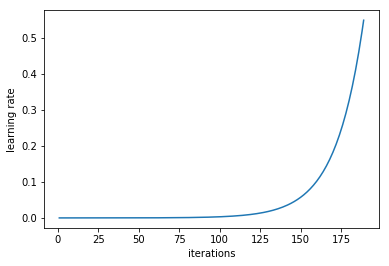

In [20]:
learn.sched.plot_lr()

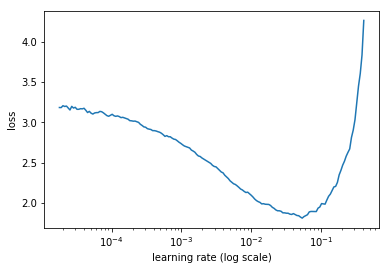

In [21]:
# plot of loss versus learning rate
learn.sched.plot()

### Improving our model
---

In [22]:
learn.fit(1e-3, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      1.218795   0.707281   0.811111  



[0.7072805, 0.811111111442248]

In [23]:
learn.precompute=False

In [24]:
learn.fit(1e-3, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.962814   0.566691   0.845139  
    1      0.8189     0.50706    0.842014                    
    2      0.774472   0.461833   0.858681                    



[0.46183327, 0.8586805552244187]

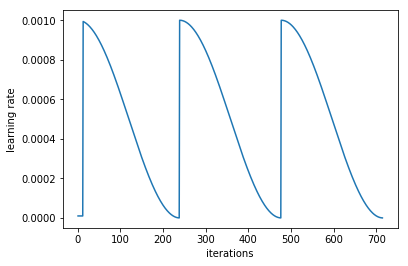

In [25]:
learn.sched.plot_lr()

In [26]:
learn.save('390_lastlayer')

In [27]:
learn.load('390_lastlayer')

In [28]:
learn.unfreeze()

In [29]:
lr = 1e-3
lrs=np.array([lr/18, lr/6, lr/2])

In [ ]:
learn.fit(lrs, 3, cycle_len=2, cycle_mult=2)

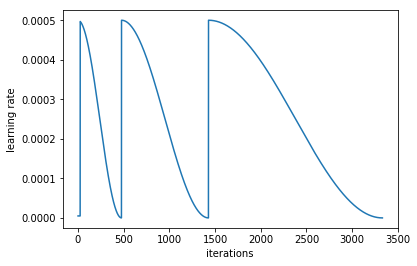

In [468]:
learn.sched.plot_lr()

In [469]:
learn.save('resnet50_390_all')

In [470]:
learn.load('resnet50_390_all')

In [471]:
log_preds, y = learn.TTA()

In [472]:
preds = np.mean(np.exp(log_preds), 0)

In [473]:
preds

array([[0.00003, 0.     , 0.00002, ..., 0.     , 0.     , 0.99927],
       [0.00002, 0.00007, 0.00007, ..., 0.00001, 0.00003, 0.99236],
       [0.00056, 0.02117, 0.91726, ..., 0.00107, 0.00643, 0.00238],
       ...,
       [0.00238, 0.00239, 0.00074, ..., 0.08521, 0.00414, 0.00252],
       [0.00371, 0.     , 0.     , ..., 0.00001, 0.00003, 0.     ],
       [0.00006, 0.99795, 0.00012, ..., 0.0009 , 0.00035, 0.00013]], dtype=float32)

In [474]:
probs = np.exp(log_preds)

In [475]:
probs

array([[[0.00007, 0.     , 0.00004, ..., 0.     , 0.     , 0.99927],
        [0.00001, 0.00001, 0.00005, ..., 0.     , 0.00001, 0.99556],
        [0.00018, 0.02147, 0.94195, ..., 0.00102, 0.0021 , 0.00347],
        ...,
        [0.00094, 0.00217, 0.00023, ..., 0.13545, 0.00141, 0.00339],
        [0.00285, 0.     , 0.     , ..., 0.     , 0.00001, 0.     ],
        [0.00011, 0.9927 , 0.00045, ..., 0.00378, 0.00055, 0.00061]],

       [[0.00003, 0.00001, 0.00002, ..., 0.     , 0.     , 0.99941],
        [0.00001, 0.00018, 0.00007, ..., 0.     , 0.00003, 0.99085],
        [0.00024, 0.03256, 0.92922, ..., 0.0011 , 0.00506, 0.00114],
        ...,
        [0.0005 , 0.00116, 0.00163, ..., 0.04758, 0.00506, 0.00083],
        [0.00196, 0.     , 0.00001, ..., 0.00001, 0.00006, 0.     ],
        [0.00005, 0.99917, 0.00003, ..., 0.00009, 0.00049, 0.00001]],

       [[0.00002, 0.     , 0.00002, ..., 0.     , 0.     , 0.99802],
        [0.00003, 0.00007, 0.00007, ..., 0.00001, 0.00007, 0.99063],
    

In [476]:
log_preds_test = learn.predict(is_test=True)
log_preds_test.shape

(794, 12)

In [477]:
metrics.log_loss(y,preds), accuracy_np(preds, y)

(0.09474803623680235, 0.9673684210526315)

### Save results and submit to kaggle
---

In [478]:
log_preds_test = np.argmax(log_preds_test, axis=1)
preds_classes = [data.classes[i].replace("_", " ") for i in log_preds_test]
probs = np.exp(log_preds_test)

In [479]:
submission = pd.DataFrame({'file': os.listdir(f'{PATH}test'), 'species': preds_classes})
submission.head(10)

file            species
0  3efa1f66c.png   Loose-Silky-bent
1  abc331628.png       Common-wheat
2  bdde957ec.png  Scentless-Mayweed
3  456d507c0.png           Cleavers
4  37714071b.png    Shepherds-Purse
5  2f0004a7f.png       Common-wheat
6  e1809cef2.png  Scentless-Mayweed
7  4f83143e1.png              Maize
8  4f44ca525.png   Common-Chickweed
9  17529c555.png  Scentless-Mayweed

In [480]:
submission.species.value_counts()

Loose-Silky-bent             123
Common-Chickweed             102
Scentless-Mayweed             89
Small-flowered-Cranesbill     80
Sugar-beet                    76
Fat-Hen                       65
Charlock                      62
Cleavers                      48
Shepherds-Purse               45
Black-grass                   37
Maize                         36
Common-wheat                  31
Name: species, dtype: int64

In [481]:
submission2 = submission.copy()
submission2.head(10)

file            species
0  3efa1f66c.png   Loose-Silky-bent
1  abc331628.png       Common-wheat
2  bdde957ec.png  Scentless-Mayweed
3  456d507c0.png           Cleavers
4  37714071b.png    Shepherds-Purse
5  2f0004a7f.png       Common-wheat
6  e1809cef2.png  Scentless-Mayweed
7  4f83143e1.png              Maize
8  4f44ca525.png   Common-Chickweed
9  17529c555.png  Scentless-Mayweed

In [482]:
submission2[submission2.species=='Loose-Silky-bent'] = 'Loose Silky-bent'
submission2[submission2.species=='Common-Chickweed'] = 'Common Chickweed'
submission2[submission2.species=='Scentless-Mayweed'] = 'Scentless Mayweed'
submission2[submission2.species=='Small-flowered-Cranesbill'] = 'Small-flowered Cranesbill'
submission2[submission2.species=='Sugar-beet'] = 'Sugar beet'
submission2[submission2.species=='Fat-Hen'] = 'Fat Hen'
submission2[submission2.species=='Shepherds-Purse'] = 'Shepherds Purse'
submission2[submission2.species=='Common-wheat'] = 'Common wheat'
submission2.head(10)

file            species
0   Loose Silky-bent   Loose Silky-bent
1       Common wheat       Common wheat
2  Scentless Mayweed  Scentless Mayweed
3      456d507c0.png           Cleavers
4    Shepherds Purse    Shepherds Purse
5       Common wheat       Common wheat
6  Scentless Mayweed  Scentless Mayweed
7      4f83143e1.png              Maize
8   Common Chickweed   Common Chickweed
9  Scentless Mayweed  Scentless Mayweed

In [483]:
submission2.species.value_counts()

Loose Silky-bent             123
Common Chickweed             102
Scentless Mayweed             89
Small-flowered Cranesbill     80
Sugar beet                    76
Fat Hen                       65
Charlock                      62
Cleavers                      48
Shepherds Purse               45
Black-grass                   37
Maize                         36
Common wheat                  31
Name: species, dtype: int64

In [484]:
submission.to_csv('data/seedlings/adas-submission-2.csv', index=False)